In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 0)

import spacy

from pymystem3 import Mystem
m = Mystem()

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("russian") 
nltk.download('stopwords')

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import scipy.sparse

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

from scikeras.wrappers import KerasClassifier
import time

import math
import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/balyadavid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('labeled.csv')

In [3]:
def tokenize_sentence(sentence):
    sentence_without_punctuation = re.sub(r'[^\w\s]', ' ', sentence)
    sentence_without_numbers = re.sub(r'[0-9]', ' ', sentence_without_punctuation)
    lemmas = ''.join(m.lemmatize(sentence_without_numbers))
    tokens = word_tokenize(lemmas, language="russian")
    return tokens

In [4]:
features = df['comment']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=244466666)

In [5]:
count_tf_idf = TfidfVectorizer(tokenizer=tokenize_sentence, min_df=3, max_df=1.0)
features_train_tf = count_tf_idf.fit_transform(features_train)
features_test_tf = count_tf_idf.transform(features_test)

In [6]:
df_train = pd.DataFrame.sparse.from_spmatrix(features_train_tf, columns=count_tf_idf.get_feature_names())#.iloc[:, :2]
Y_train = np.array(target_train)
X_train = np.array(df_train)

df_test = pd.DataFrame.sparse.from_spmatrix(features_test_tf, columns=count_tf_idf.get_feature_names())
Y_test = np.array(target_test)
X_test = np.array(df_test)

In [7]:
class DNN:
    def __init__(self, sizes, epochs, lr, batch):
        self.sizes = sizes
        self.epochs = epochs
        self.lr = lr
        self.batch = batch

        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        output_layer=self.sizes[2]

        self.w_1 = np.random.randn(hidden_1, input_layer) * np.sqrt(2/input_layer)  #128x8884
        self.b_1 = np.zeros((1, hidden_1))                                          #1x128
        
        self.w_2 = np.random.randn(output_layer, hidden_1) * np.sqrt(2/hidden_1)    #1x128
        self.b_2 = np.zeros((output_layer, 1))                                      #1x2
    
    def ReLU(self, x):
        return np.maximum(0,x)

    def d_ReLU(self, x):
        return 1 * (x > 0)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def d_sigmoid(self, x):
        return self.sigmoid(x) / (1 + self.sigmoid(x))
    
    def cross_entropy(self, y_pred, y_true):
        y_pred = y_pred.reshape(-1, 1)
        y_true = y_true.reshape(-1, 1)
        term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
        term_1 = y_true * np.log(y_pred + 1e-7)
        return -np.mean(term_0+term_1, axis=0)
    
    def d_cross_entropy(self, y_pred, y_true):
        y_pred = y_pred.reshape(-1, 1)
        y_true = y_true.reshape(-1, 1)
        return -((y_true/y_pred) - ((1-y_true)/(1-y_pred)))

    def forward_pass(self, x_train):
        a_0 = x_train
        self.a_0 = a_0
        z_1 = a_0 @ self.w_1.T + self.b_1
        a_1 = self.ReLU(z_1)
        self.a_1 = a_1
                
        z_2 = a_1 @ self.w_2.T + self.b_2
        a_2 = self.sigmoid(z_2)
        return a_2
        
    def backward_pass(self, y_train, output):
        error_2 = self.d_cross_entropy(output, y_train) * self.d_sigmoid(output)        
        self.change_w_2 = error_2.T @ self.a_1
        self.change_b_2 = np.sum(error_2, axis=0)

        error_1 = error_2 @ self.w_2 * self.d_ReLU(self.a_1)
        self.change_w_1 = error_1.T @ self.a_0
        self.change_b_1 = np.sum(error_1, axis=0)

    def update_network_parameters(self):
        self.w_2 -= self.lr * self.change_w_2
        self.b_2 -= self.lr * self.change_b_2
        self.w_1 -= self.lr * self.change_w_1
        self.b_1 -= self.lr * self.change_b_1       

    def compute_accuracy(self, X_test, Y_test):
        return np.sum(((self.forward_pass(X_test) > 0.5)+0) == Y_test) / len(Y_test)

    def train(self, X_train, Y_train, X_test, Y_test):
        ce_hist=[]
        ac_hist=[]
        pr_hist=[]
        rec_hist=[]
        f_1_hist=[]
        roc_hist=[]
        
        for i in range(self.epochs):
            
            for j in range(self.batch, X_train.shape[0]+1, self.batch):
                x = X_train[j - self.batch: j]
                y = Y_train[j - self.batch: j]
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters()   

            ce_hist.append(self.cross_entropy(self.forward_pass(X_test), Y_test))
            ac_hist.append(accuracy_score(((self.forward_pass(X_test) > 0.5)+0).ravel(), Y_test))
            
            model_pred = ((self.forward_pass(X_test) > 0.5)+0).ravel()
            probabilities = self.forward_pass(X_test)

            probas = []
            for prob in probabilities:
                probas.append(prob[0])

            fpr, tpr, thresholds = roc_curve(Y_test, probas)
                
            pr_hist.append(round(precision_score(Y_test, model_pred), 4))
            rec_hist.append(round(recall_score(Y_test, model_pred), 4))
            f_1_hist.append(round(f1_score(Y_test, model_pred), 4))
            roc_hist.append(round(roc_auc_score(Y_test, model_pred), 4))
                
            self.ce_hist = ce_hist
            self.ac_hist = ac_hist
            self.pr_hist = pr_hist
            self.rec_hist = rec_hist
            self.f_1_hist = f_1_hist
            self.roc_hist = roc_hist
            
        print("\r" + 'Epoch: '+str(i + 1)+' Accuracy: '+str(ac_hist[i])+' Binary CE: '+str(ce_hist[i])+'    ')
        print('')
        print('roc_auc:', round(roc_auc_score(Y_test, model_pred), 4))
        print('f1_score:', round(f1_score(Y_test, model_pred), 4))
        print('precision_score:', round(precision_score(Y_test, model_pred), 4))
        print('recall_score:', round(recall_score(Y_test, model_pred), 4))
        print('accuracy_score:', round(accuracy_score(Y_test, model_pred), 4))
        print(self.forward_pass(X_test)[:5]) 
        print('')
        
    def ce_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.ce_hist)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
    
    def acc_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.ac_hist)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")   
        
    def pr_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.pr_hist)
        plt.xlabel("Epochs")
        plt.ylabel("precision")
        
    def rec_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.rec_hist)
        plt.xlabel("Epochs")
        plt.ylabel("recall")
        
    def f_1_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.f_1_hist)
        plt.xlabel("Epochs")
        plt.ylabel("F_1")
        
    def roc_plot(self):
        plt.figure(dpi = 125)
        plt.plot(self.roc_hist)
        plt.xlabel("Epochs")
        plt.ylabel("roc_auc")  

## Neural network training on unbalanced data

In [8]:
dnn = DNN(sizes=[8884, 128, 1], epochs=128, lr=0.0001, batch=128)

In [9]:
dnn.train(X_train, Y_train, X_test, Y_test)

Epoch: 128 Accuracy: 0.8622962192160943 Binary CE: [0.33472149]    

roc_auc: 0.8199
f1_score: 0.772
precision_score: 0.8784
recall_score: 0.6885
accuracy_score: 0.8623
[[0.9278653 ]
 [0.03325444]
 [0.05613419]
 [0.97118327]
 [0.48019066]]



Epoch: 126 Accuracy: 0.8640305237599722 CE: [0.33471265]    

roc_auc: 0.8224  
f1_score: 0.7755  
precision_score: 0.8792  
recall_score: 0.6936  
accuracy_score: 0.864  

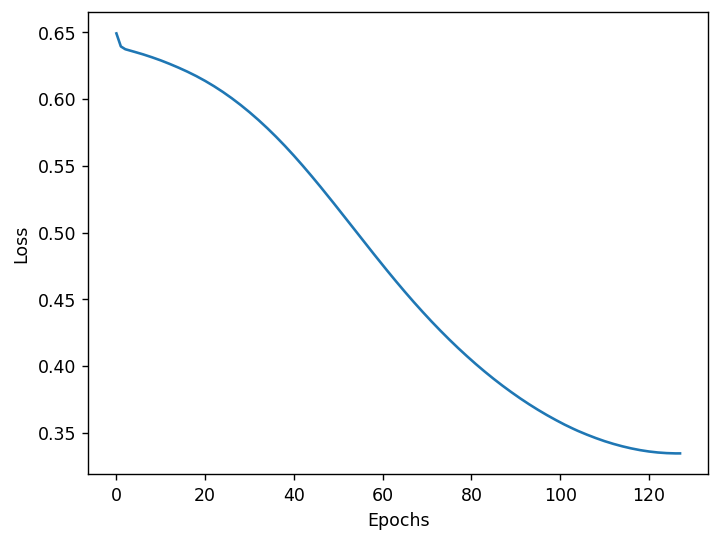

In [10]:
dnn.ce_plot()

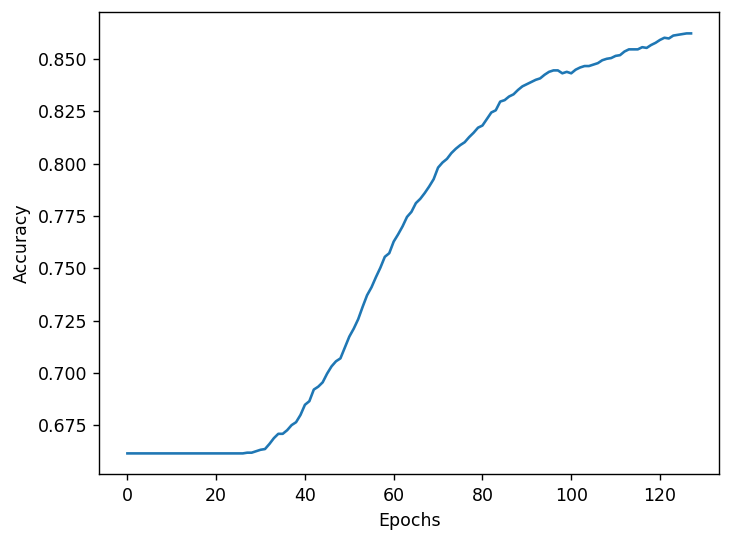

In [11]:
dnn.acc_plot()

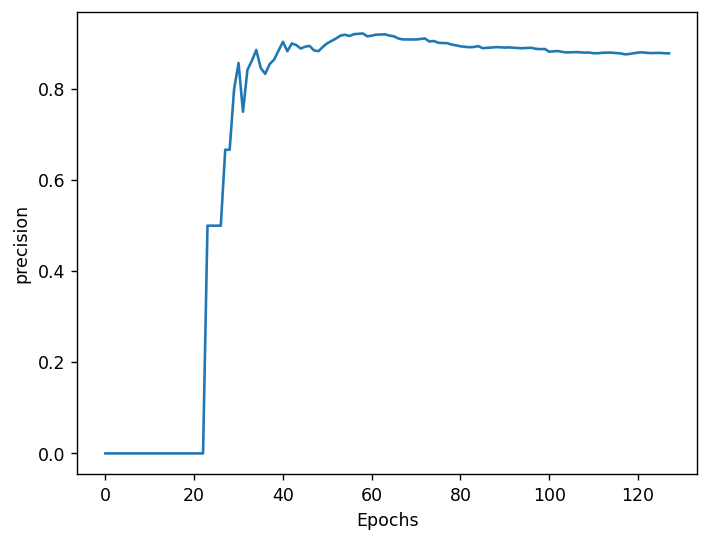

In [12]:
dnn.pr_plot()

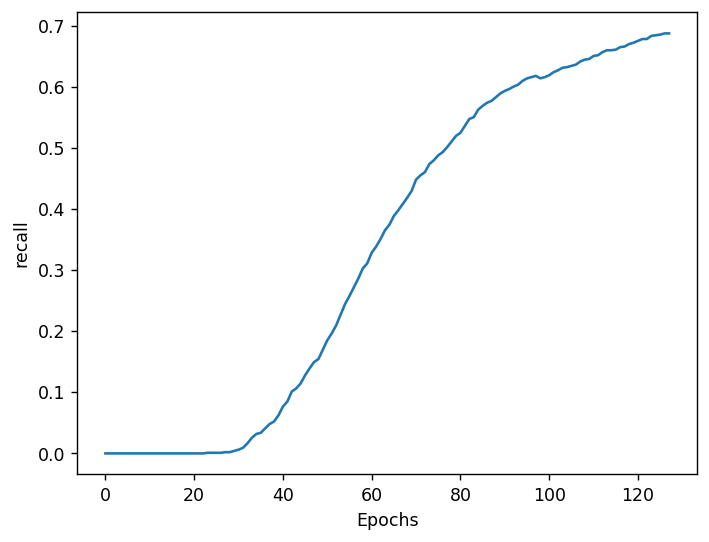

In [13]:
dnn.rec_plot()

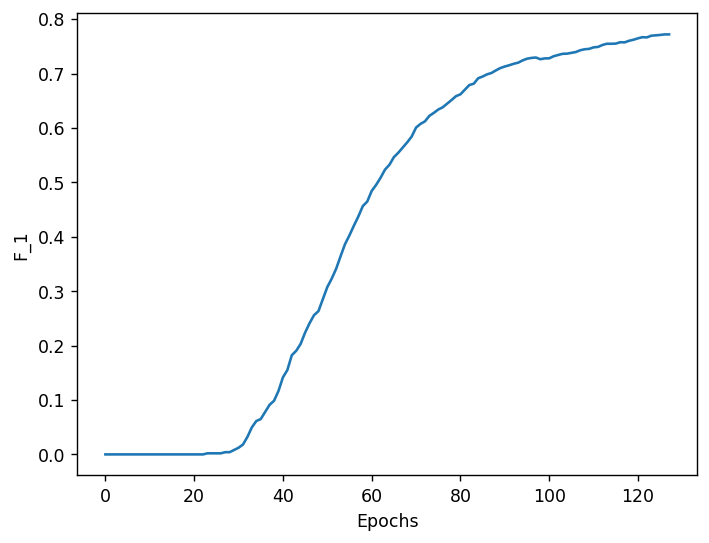

In [14]:
dnn.f_1_plot()

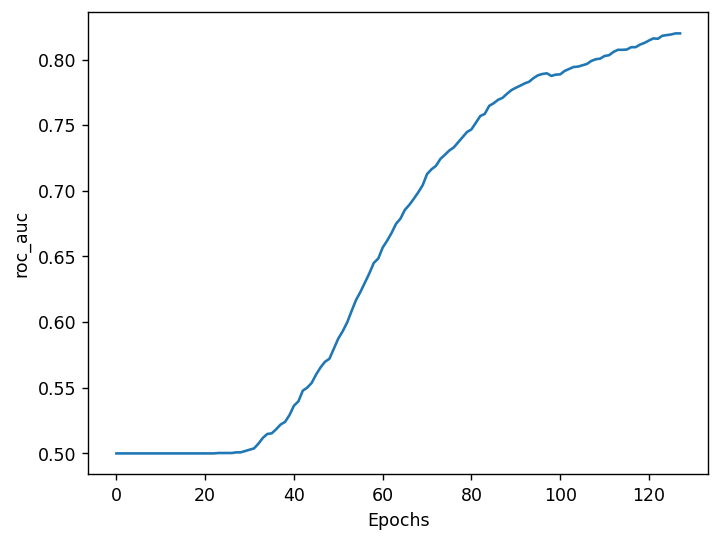

In [15]:
dnn.roc_plot()

## Neural network training on balanced data (oversampling)

In [16]:
ros = RandomOverSampler(random_state=244466666)

In [17]:
features_train_resampled, target_train_resampled = ros.fit_resample(features_train_tf, target_train)

In [18]:
df_train = pd.DataFrame.sparse.from_spmatrix(features_train_resampled, columns=count_tf_idf.get_feature_names())#.iloc[:, :2]
Y_train = np.array(target_train_resampled)
X_train = np.array(df_train)

df_test = pd.DataFrame.sparse.from_spmatrix(features_test_tf, columns=count_tf_idf.get_feature_names())
Y_test = np.array(target_test)
X_test = np.array(df_test)

In [19]:
dnn_ros = DNN(sizes=[8884, 128, 1], epochs=851, lr=0.00001, batch=128)

In [20]:
dnn_ros.train(X_train, Y_train, X_test, Y_test)

Epoch: 851 Accuracy: 0.8005549774540409 Binary CE: [0.43236083]    

roc_auc: 0.8275
f1_score: 0.7556
precision_score: 0.6456
recall_score: 0.9109
accuracy_score: 0.8006
[[0.97473248]
 [0.21936378]
 [0.48126014]
 [0.98733968]
 [0.84547069]]



Epoch: 851 Accuracy: 0.8040235865417967 CE: [0.43144782]    

roc_auc: 0.833  
f1_score: 0.7622  
precision_score: 0.6542  
recall_score: 0.9119  
accuracy_score: 0.8071  

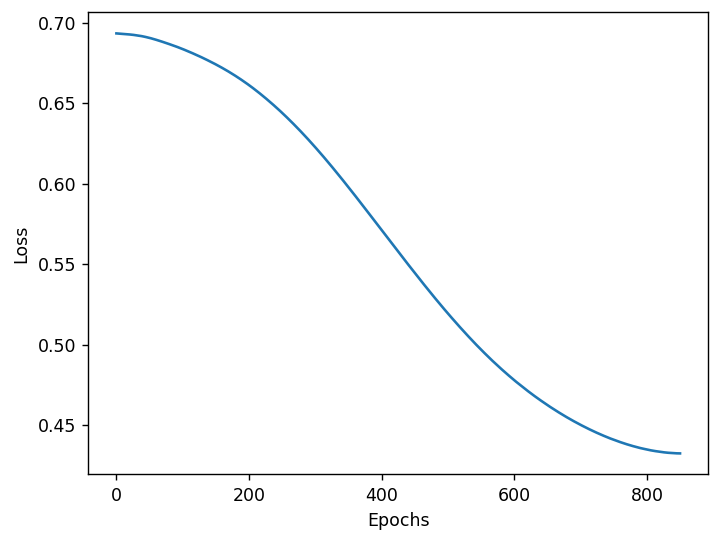

In [21]:
dnn_ros.ce_plot()

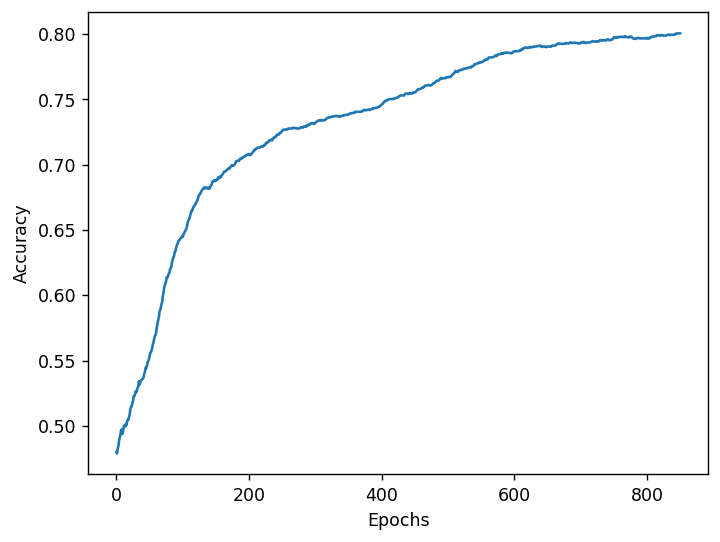

In [22]:
dnn_ros.acc_plot()

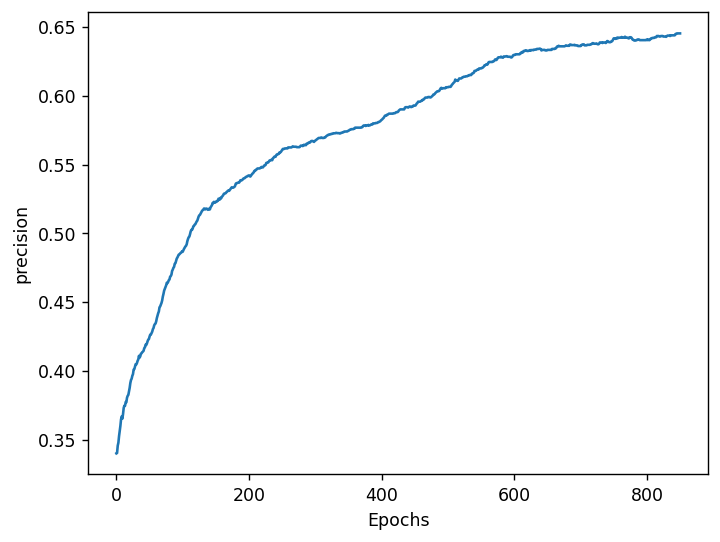

In [23]:
dnn_ros.pr_plot()

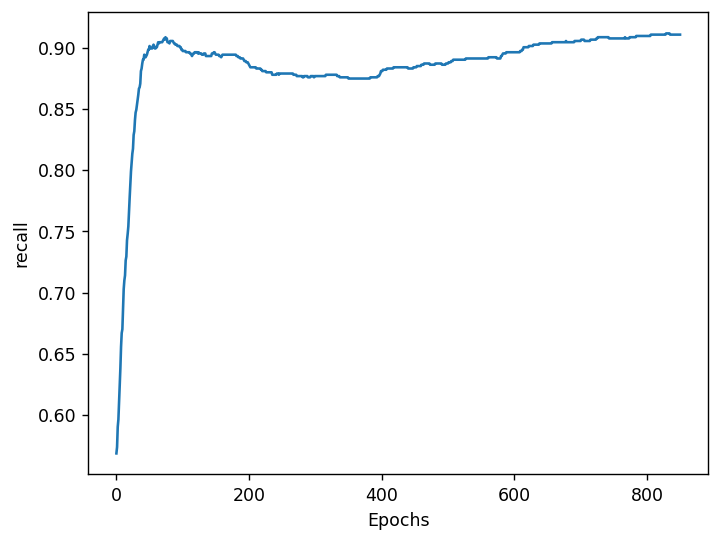

In [24]:
dnn_ros.rec_plot()

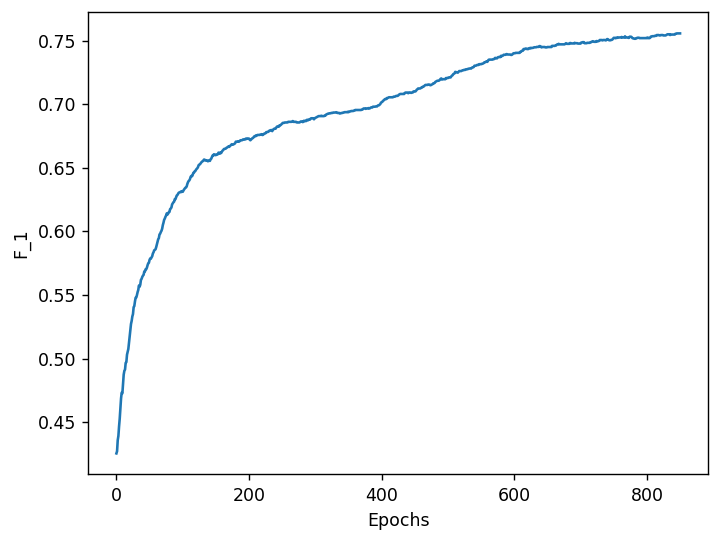

In [25]:
dnn_ros.f_1_plot()

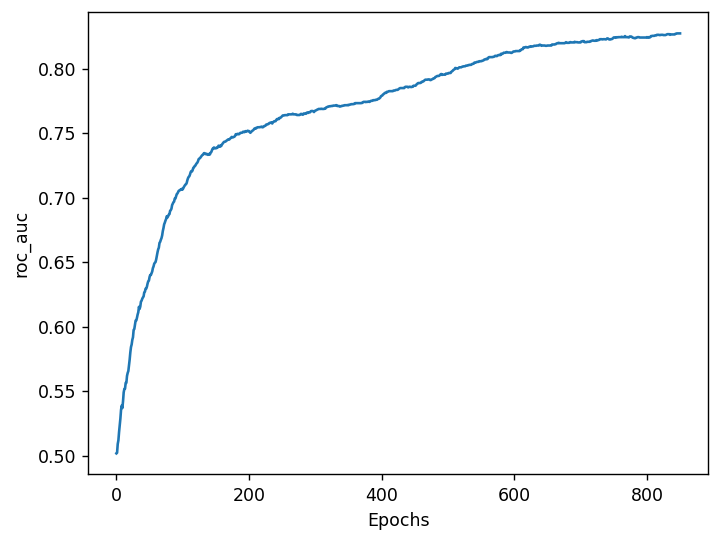

In [26]:
dnn_ros.roc_plot()

## Neural network training on balanced data (undersampling)

In [27]:
rus = RandomUnderSampler(random_state=244466666)

In [28]:
features_train_resampled, target_train_resampled = rus.fit_resample(features_train_tf, target_train)

In [29]:
df_train = pd.DataFrame.sparse.from_spmatrix(features_train_resampled, columns=count_tf_idf.get_feature_names())#.iloc[:, :2]
Y_train = np.array(target_train_resampled)
X_train = np.array(df_train)

df_test = pd.DataFrame.sparse.from_spmatrix(features_test_tf, columns=count_tf_idf.get_feature_names())
Y_test = np.array(target_test)
X_test = np.array(df_test)

In [30]:
dnn_rus = DNN(sizes=[8884, 128, 1], epochs=1576, lr=0.00001, batch=128)

In [31]:
dnn_rus.train(X_train, Y_train, X_test, Y_test)

Epoch: 1576 Accuracy: 0.7898022892819979 Binary CE: [0.45282448]    

roc_auc: 0.8194
f1_score: 0.7458
precision_score: 0.6314
recall_score: 0.9109
accuracy_score: 0.7898
[[0.96430434]
 [0.22216046]
 [0.29475804]
 [0.97876264]
 [0.83681463]]



Epoch: 1576 Accuracy: 0.7845993756503642 CE: [0.45429594]    

roc_auc: 0.8169  
f1_score: 0.7426  
precision_score: 0.6249  
recall_score: 0.915  
accuracy_score: 0.7853  

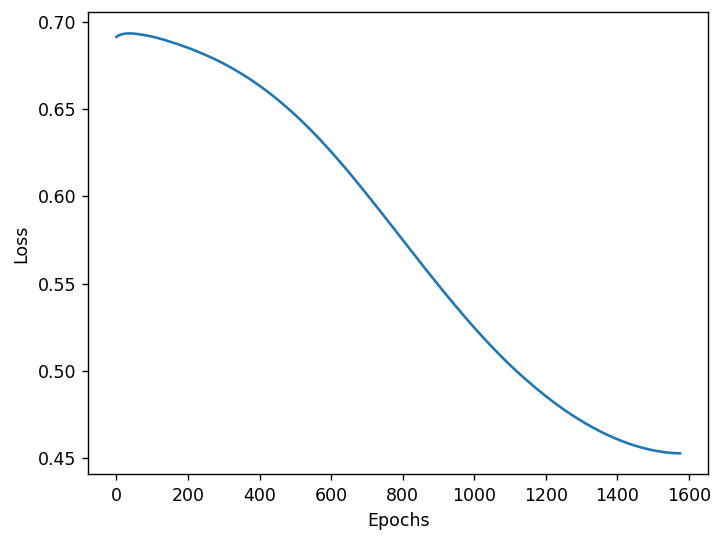

In [32]:
dnn_rus.ce_plot()

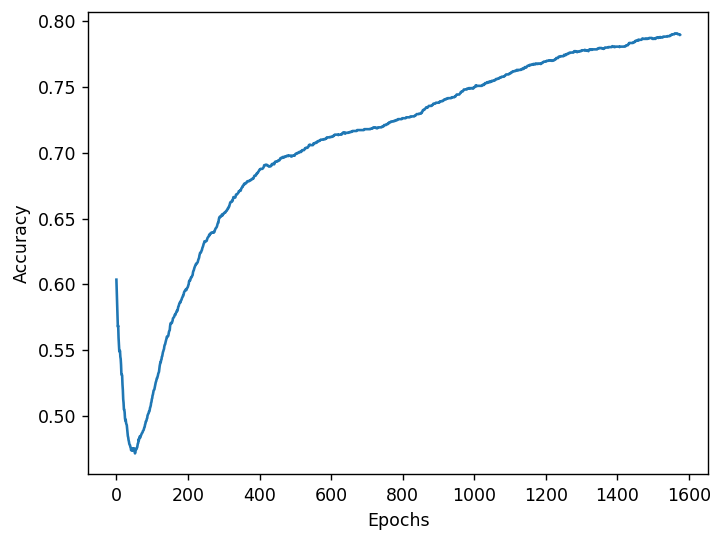

In [33]:
dnn_rus.acc_plot()

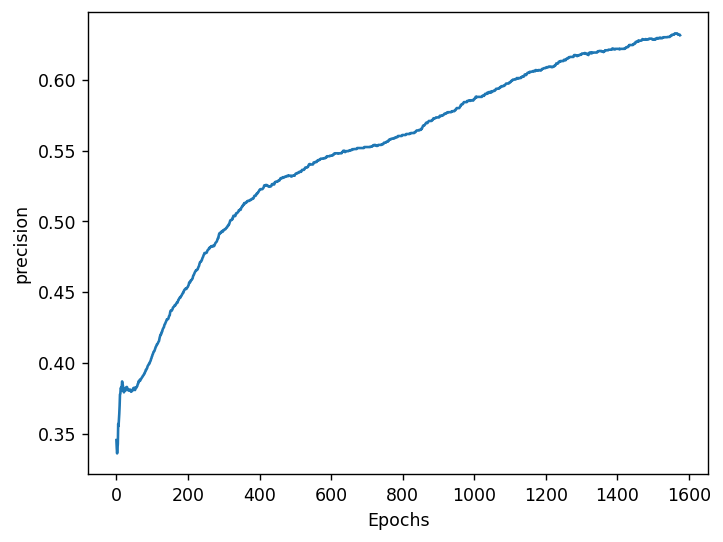

In [34]:
dnn_rus.pr_plot()

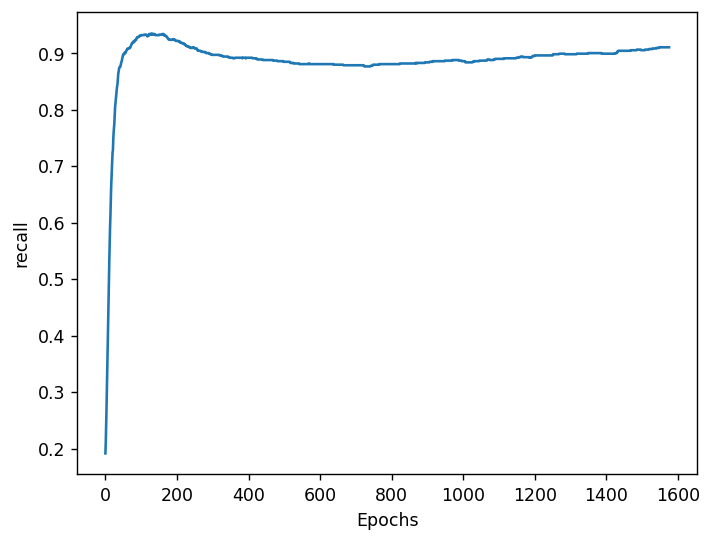

In [35]:
dnn_rus.rec_plot()

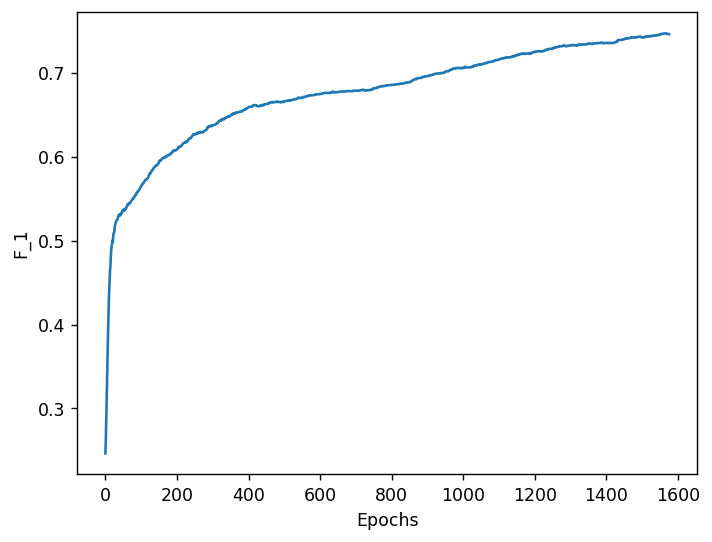

In [36]:
dnn_rus.f_1_plot()

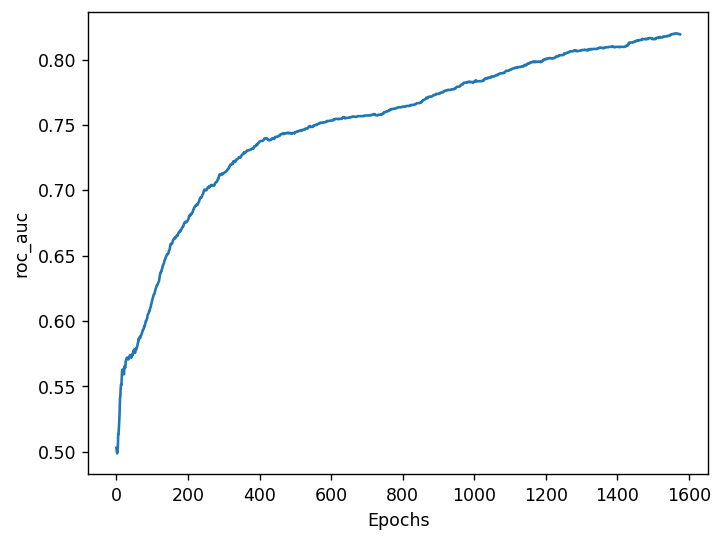

In [37]:
dnn_rus.roc_plot()

## Keras neural network traning

In [44]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(features_train_tf.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

In [45]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
             metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1137280   
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,137,409
Trainable params: 1,137,409
Non-trainable params: 0
_________________________________________________________________


In [47]:
features_train_tf_1 = pd.DataFrame.sparse.from_spmatrix(features_train_tf, columns=count_tf_idf.get_feature_names()).iloc[:,:].values
features_test_tf_1 = pd.DataFrame.sparse.from_spmatrix(features_test_tf, columns=count_tf_idf.get_feature_names()).iloc[:,:].values
features_train_tf_1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
history = model.fit(features_train_tf_1, target_train, batch_size=128, epochs=300, verbose=None)

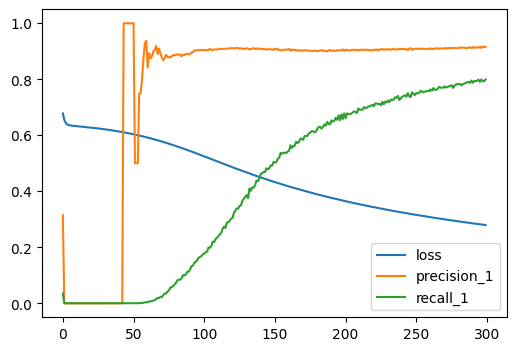

In [49]:
pd.DataFrame(history.history).plot(figsize=(6,4))
plt.show()

91/91 [==============================] - 0s 698us/step
roc_auc: 0.8355
f1_score: 0.7939
precision_score: 0.8904
recall_score: 0.7162
accuracy_score: 0.8741


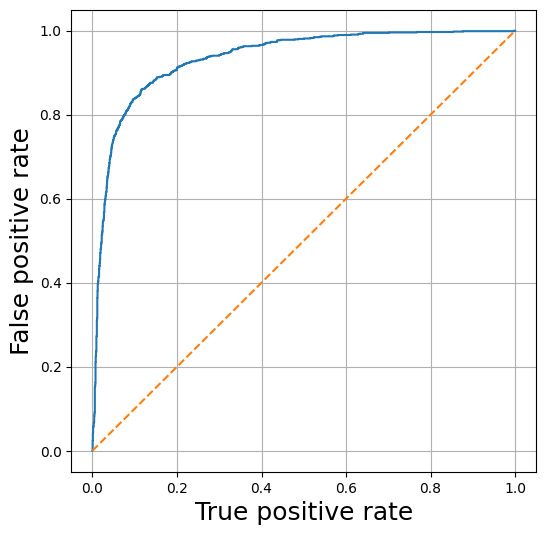

In [55]:
probabilities = model.predict(features_test_tf_1)
model_pred = ((probabilities > 0.5)+0).ravel()
fpr, tpr, thresholds = roc_curve(target_test, probabilities)
    
print('roc_auc:', round(roc_auc_score(target_test, model_pred), 4))
print('f1_score:', round(f1_score(target_test, model_pred), 4))
print('precision_score:', round(precision_score(target_test, model_pred), 4))
print('recall_score:', round(recall_score(target_test, model_pred), 4))
print('accuracy_score:', round(accuracy_score(target_test, model_pred), 4))

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('True positive rate', fontsize = 18)
plt.ylabel('False positive rate', fontsize = 18)
plt.grid()
    
plt.show()